In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow import keras

In [2]:
df = read_csv('data/data_single_loc.csv')
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,0.0,2020-12-31 22:00:00,0.649268,0.561700


In [25]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 2]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

def data_prep(df, n_hours):

    train = df[df['Date Time']>='1994-01-01']
    train = train[train['Date Time']<'2002-01-01']
    test = df[df['Date Time']>='2002-01-01']
    test = test[test['Date Time']<'2003-01-01']

    train = datetimeToSignal(train)
    test = datetimeToSignal(test)

    values_train = train.values
    values_test = test.values

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values_train)
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

    values_train = scaler.transform(values_train)
    values_test = scaler.transform(values_test)

    X_train, y_train = to_supervised(values_train, n_input=24, n_out=n_hours)
    X_test, y_test = to_supervised(values_test, n_input=24, n_out=n_hours)

    return X_train, y_train, X_test, y_test, scaler_y

In [26]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, scaler_y, display = True, save_to = ''):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$Mean sea level pressure[Pa]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])
        plt.savefig(save_to)

    return testScore, testPredictions, testYTrue

def cross_corr(model, X_test, y_test, scaler_y):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")

In [5]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

Epoch 1/20
2191/2191 [==============================] - 23s 10ms/step - loss: 0.0016
Epoch 2/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 3/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 4/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 5/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Test Score: 0.7760 RMSE
Epoch 1/20
2191/2191 [==============================] - 25s 11ms/step - loss: 0.0042
Epoch 2/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0041
Epoch 3/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0041
Epoch 4/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0041
Epoch 5/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0041
Epoch 6/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0041
Epoch 7/20
2191/2191 [===================

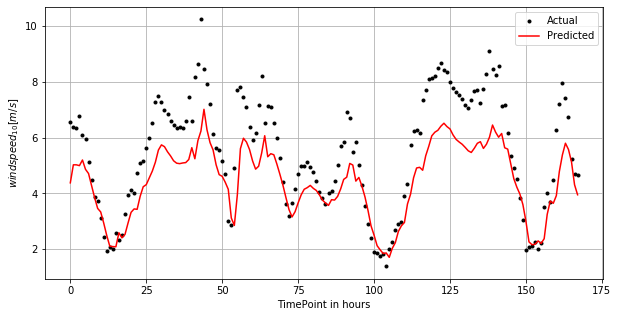

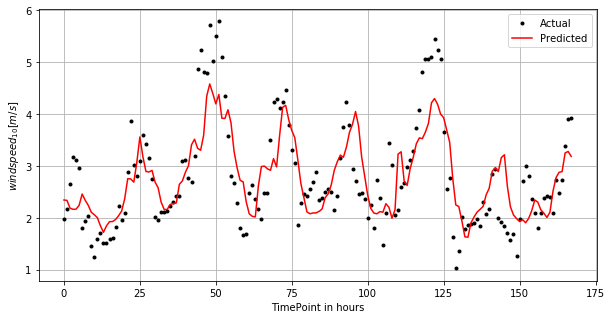

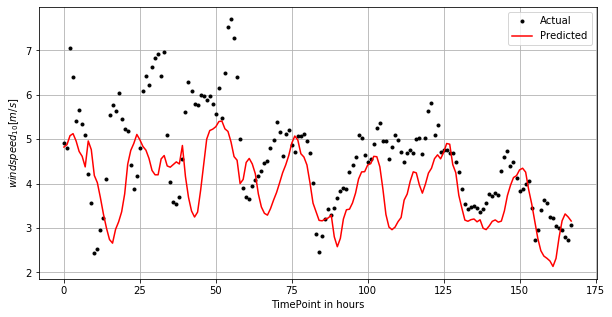

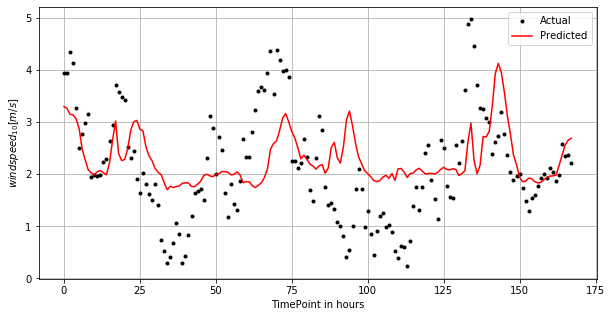

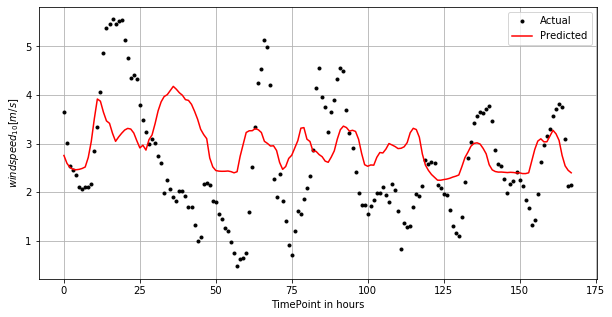

In [14]:
hours_forward = [1, 3, 6, 9, 12]
scores = {}
predictions = {}
actuals = {}

for n in hours_forward:
    X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=n)
    compile_and_fit(dense, X_train, y_train)
    testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True, save_to='workdir/figures/lag_study/results_nh{}.png'.format(n))
    scores[n] = testScore
    predictions[n] = testPredictions
    actuals[n] = testYTrue
    

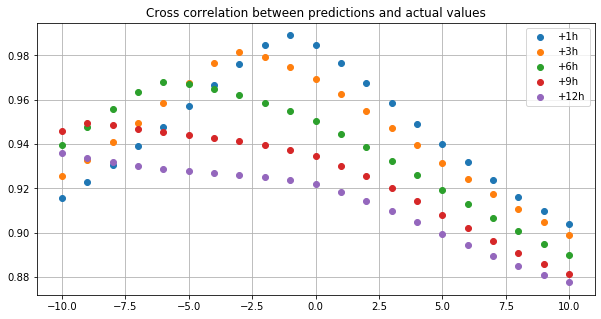

In [16]:
plt.figure(figsize=[10,5])
plt.grid()
plt.title("Cross correlation between predictions and actual values")
labels = []
for n in hours_forward:
    plt.xcorr(actuals[n].reshape((actuals[n].shape[0])), predictions[n].reshape((predictions[n].shape[0])), usevlines=False)
    labels.append("+{}h".format(n))
plt.legend(labels)

Windspeed100:

Epoch 1/20
2191/2191 [==============================] - 23s 10ms/step - loss: 0.0022
Epoch 2/20
2191/2191 [==============================] - 22s 10ms/step - loss: 0.0018
Epoch 3/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0017
Epoch 4/20
2191/2191 [==============================] - 23s 10ms/step - loss: 0.0016
Epoch 5/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 6/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 7/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 8/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0016
Epoch 9/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0015
Epoch 10/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0015
Epoch 11/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0015
Epoch 12/20
2191/2191 [==============================] - 24s 11

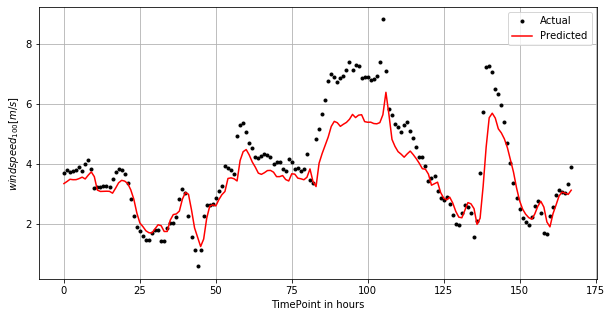

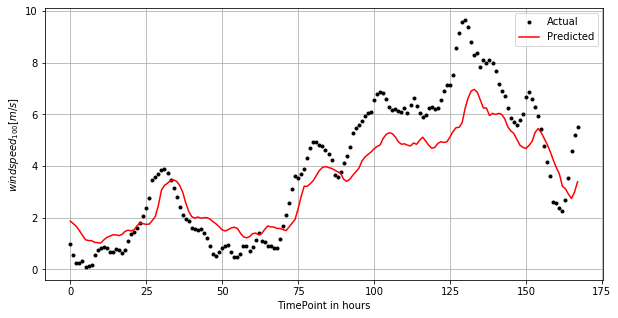

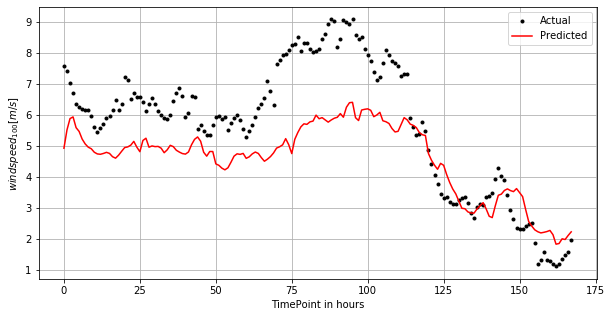

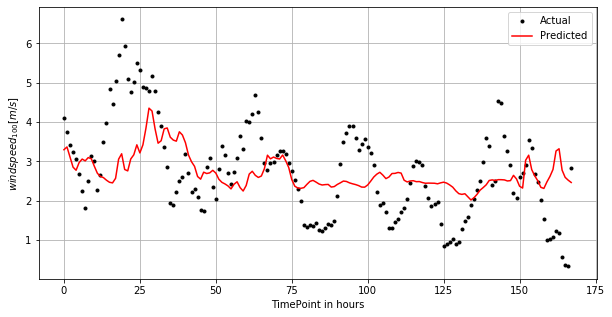

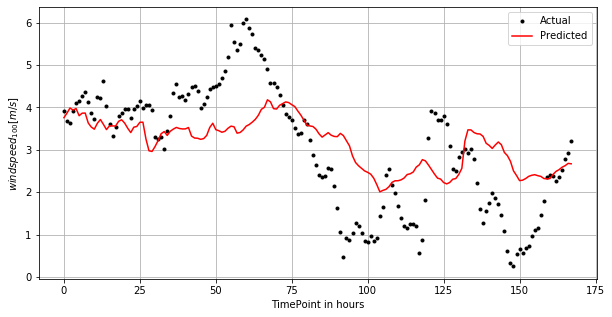

In [19]:
hours_forward = [1, 3, 6, 9, 12]
scores = {}
predictions = {}
actuals = {}

for n in hours_forward:
    X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=n)
    compile_and_fit(dense, X_train, y_train)
    testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True, save_to='workdir/figures/lag_study/results_nh{}.png'.format(n))
    scores[n] = testScore
    predictions[n] = testPredictions
    actuals[n] = testYTrue
    

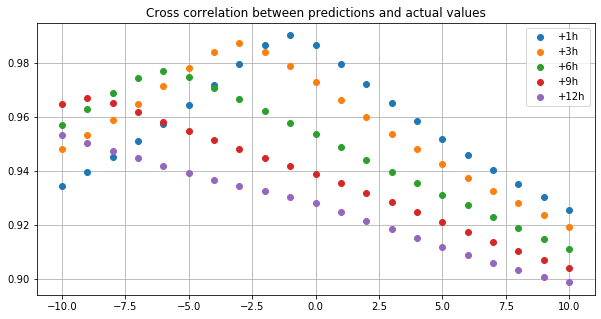

In [20]:
plt.figure(figsize=[10,5])
plt.grid()
plt.title("Cross correlation between predictions and actual values")
labels = []
for n in hours_forward:
    plt.xcorr(actuals[n].reshape((actuals[n].shape[0])), predictions[n].reshape((predictions[n].shape[0])), usevlines=False)
    labels.append("+{}h".format(n))
plt.legend(labels)

Temperature:

Epoch 1/20
2191/2191 [==============================] - 23s 10ms/step - loss: 0.0057
Epoch 2/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0016
Epoch 3/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0012
Epoch 4/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0011
Epoch 5/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0010
Epoch 6/20
2191/2191 [==============================] - 23s 11ms/step - loss: 9.4573e-04
Epoch 7/20
2191/2191 [==============================] - 23s 11ms/step - loss: 8.8195e-04
Epoch 8/20
2191/2191 [==============================] - 23s 11ms/step - loss: 8.3000e-04
Epoch 9/20
2191/2191 [==============================] - 23s 11ms/step - loss: 7.9443e-04
Epoch 10/20
2191/2191 [==============================] - 24s 11ms/step - loss: 7.6009e-04
Epoch 11/20
2191/2191 [==============================] - 24s 11ms/step - loss: 7.3606e-04
Epoch 12/20
2191/2191 [================

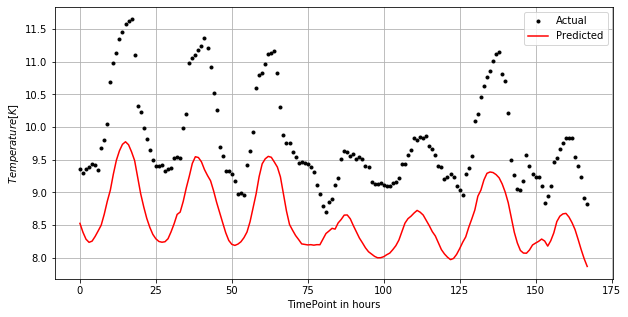

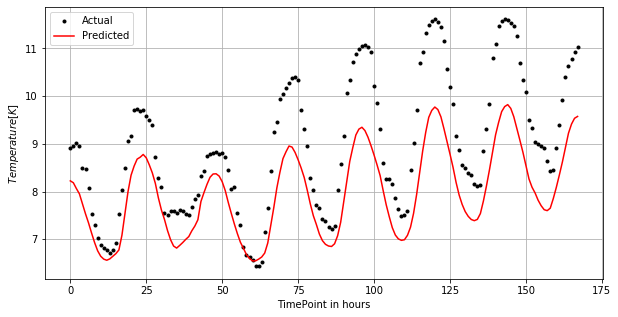

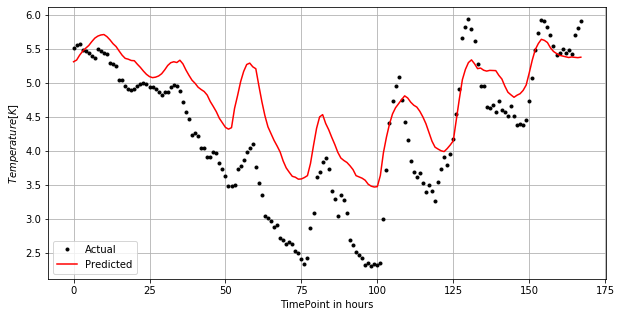

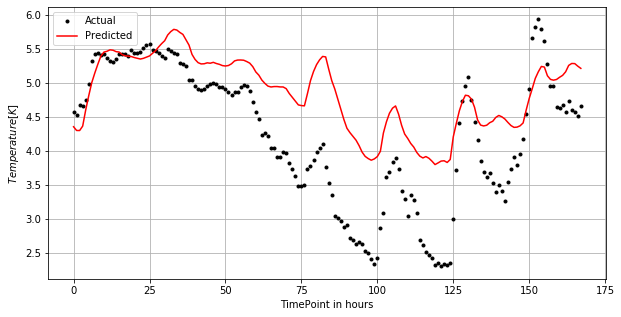

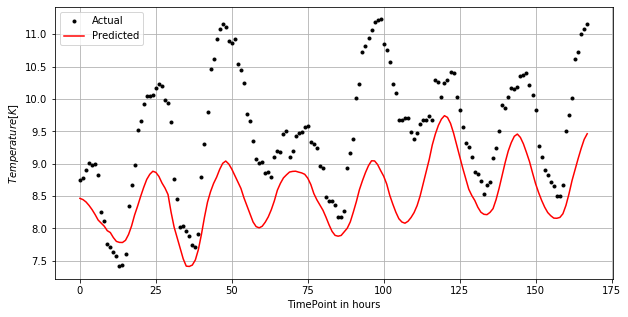

In [23]:
hours_forward = [1, 3, 6, 9, 12]
scores = {}
predictions = {}
actuals = {}

for n in hours_forward:
    X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=n)
    compile_and_fit(dense, X_train, y_train)
    testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True, save_to='workdir/figures/lag_study/results_nh{}.png'.format(n))
    scores[n] = testScore
    predictions[n] = testPredictions
    actuals[n] = testYTrue
    

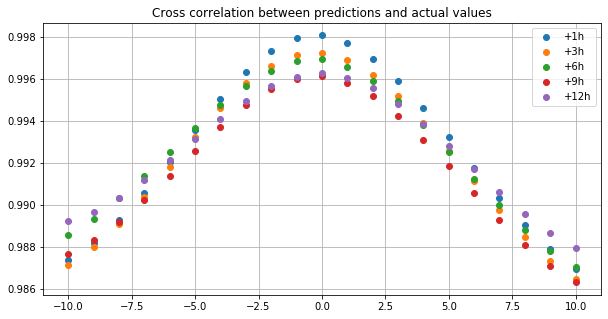

In [24]:
plt.figure(figsize=[10,5])
plt.grid()
plt.title("Cross correlation between predictions and actual values")
labels = []
for n in hours_forward:
    plt.xcorr(actuals[n].reshape((actuals[n].shape[0])), predictions[n].reshape((predictions[n].shape[0])), usevlines=False)
    labels.append("+{}h".format(n))
plt.legend(labels)

Pressure:

Epoch 1/20
2191/2191 [==============================] - 23s 10ms/step - loss: 0.0064
Epoch 2/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0017
Epoch 3/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0013
Epoch 4/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0010
Epoch 5/20
2191/2191 [==============================] - 24s 11ms/step - loss: 8.5710e-04
Epoch 6/20
2191/2191 [==============================] - 24s 11ms/step - loss: 7.8581e-04
Epoch 7/20
2191/2191 [==============================] - 23s 11ms/step - loss: 7.5451e-04
Epoch 8/20
2191/2191 [==============================] - 24s 11ms/step - loss: 7.1310e-04
Epoch 9/20
2191/2191 [==============================] - 23s 11ms/step - loss: 6.9463e-04
Epoch 10/20
2191/2191 [==============================] - 24s 11ms/step - loss: 6.7550e-04
Epoch 11/20
2191/2191 [==============================] - 24s 11ms/step - loss: 6.6021e-04
Epoch 12/20
2191/2191 [============

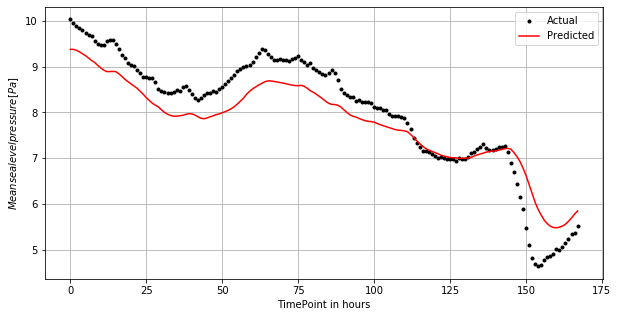

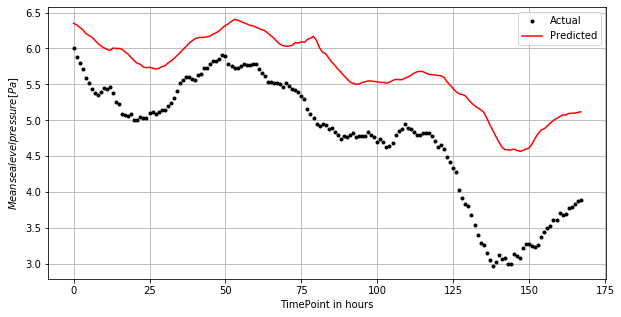

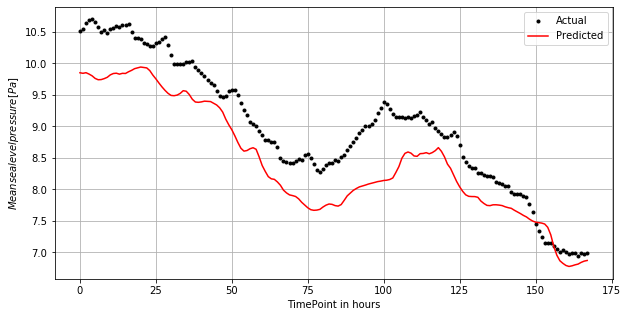

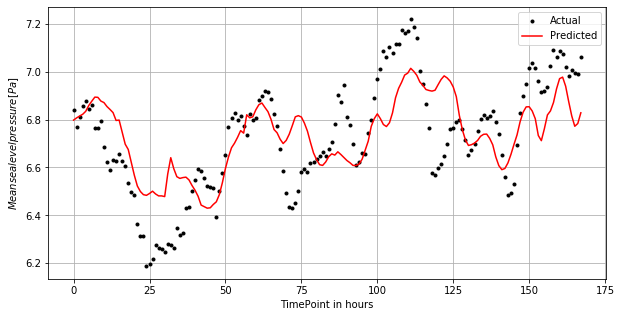

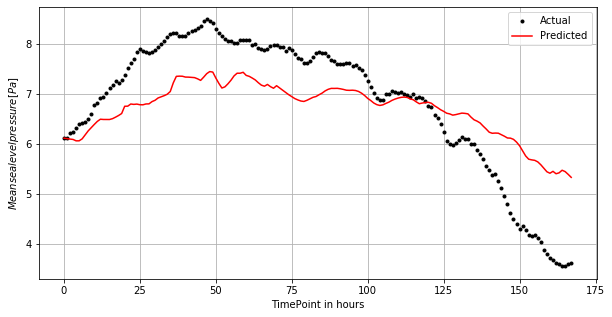

In [27]:
hours_forward = [1, 3, 6, 9, 12]
scores = {}
predictions = {}
actuals = {}

for n in hours_forward:
    X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=n)
    compile_and_fit(dense, X_train, y_train)
    testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True, save_to='workdir/figures/lag_study/results_nh{}.png'.format(n))
    scores[n] = testScore
    predictions[n] = testPredictions
    actuals[n] = testYTrue

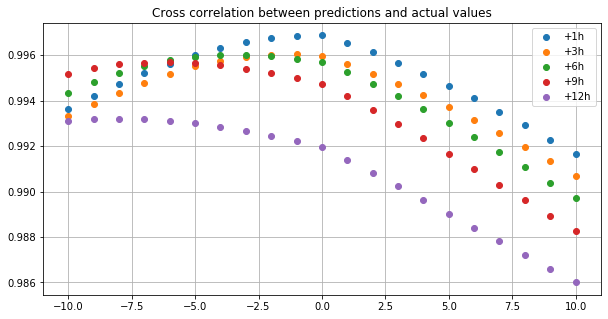

In [28]:
plt.figure(figsize=[10,5])
plt.grid()
plt.title("Cross correlation between predictions and actual values")
labels = []
for n in hours_forward:
    plt.xcorr(actuals[n].reshape((actuals[n].shape[0])), predictions[n].reshape((predictions[n].shape[0])), usevlines=False)
    labels.append("+{}h".format(n))
plt.legend(labels)